# Lecture 13:  Sparse direct solvers

## Recap of the previous part

- Distributed memory for huge dense matrices
- Sparse matrix formats (COO, CSR, CSC)
- Matrix-by-vector product
- Inefficiency of sparse matrix processing
- Approaches to reduce cache misses

## Plan for this week: how to solve large sparse linear systems

- Direct methods (start today and continue in the next lecture)
    - LU decomposition
    - Number of reordering techniques to minimize fill-in
- Krylov methods

## Plan for today

Sparse direct solvers: 

- LU decomposition of sparse matrices
- fill-in of $L$ and $U$ factors
- nested dissection
- spectral clustering in details

## Direct methods for sparse matrix: LU decomposition

- Why sparse linear systems can be solved faster, what is the technique? 

- In the LU factorization of the matrix $A$ the factors $L$ and $U$ can be also sparse:

$$A = L U$$

- And solving linear systems with **sparse** triangular matrices is very easy.  

<span style="color:red"> Note that the inverse matrix to sparse matrix is not sparse! </span>


In [1]:
import numpy as np
import scipy.sparse as spsp
n = 7
ex = np.ones(n);
a = spsp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
b = np.array(np.linalg.inv(a.toarray()))
print(a.toarray())
print(b)
np.linalg.svd(b[:3, 4:])[1]

[[-2.  1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1. -2.]]
[[-0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125]
 [-0.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25 ]
 [-0.625 -1.25  -1.875 -1.5   -1.125 -0.75  -0.375]
 [-0.5   -1.    -1.5   -2.    -1.5   -1.    -0.5  ]
 [-0.375 -0.75  -1.125 -1.5   -1.875 -1.25  -0.625]
 [-0.25  -0.5   -0.75  -1.    -1.25  -1.5   -0.75 ]
 [-0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875]]


array([1.75000000e+00, 1.65849874e-17, 1.12884010e-34])

## And the factors...

$L$ and $U$ are typically sparse. In the tridiagonal case they are even bidiagonal!

In [2]:
from scipy.sparse.linalg import splu
T = splu(a.tocsc(), permc_spec="NATURAL")
print(T.L.toarray())

[[ 1.          0.          0.          0.          0.          0.
   0.        ]
 [-0.5         1.          0.          0.          0.          0.
   0.        ]
 [ 0.         -0.66666667  1.          0.          0.          0.
   0.        ]
 [ 0.          0.         -0.75        1.          0.          0.
   0.        ]
 [ 0.          0.          0.         -0.8         1.          0.
   0.        ]
 [ 0.          0.          0.          0.         -0.83333333  1.
   0.        ]
 [ 0.          0.          0.          0.          0.         -0.85714286
   1.        ]]


Interesting to note that ```splu``` without ```permc_spec``` will produce permutations which will not yield the bidiagonal factor:

In [3]:
from scipy.sparse.linalg import splu
T = splu(a.tocsc())
print(T.L.todense())
print(T.perm_c)

[[ 1.          0.          0.          0.          0.          0.
   0.        ]
 [-0.5         1.          0.          0.          0.          0.
   0.        ]
 [ 0.         -0.66666667  1.          0.          0.          0.
   0.        ]
 [ 0.          0.         -0.75        1.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.        ]
 [ 0.          0.          0.         -0.8        -0.5         1.
   0.        ]
 [ 0.          0.          0.          0.         -0.5        -0.71428571
   1.        ]]
[0 1 2 3 5 4 6]


## 2D-case
From a matrix that comes as a discretization of  a two-dimensional problem 
everything is much worse:

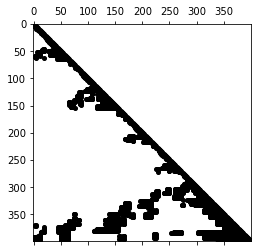

In [10]:
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
%matplotlib inline
n = 20
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = spsp.csc_matrix(A)
T = spsp.linalg.splu(A)
plt.spy(T.L, marker='.', color='k', markersize=8)
#plt.spy(A, marker='.', color='k', markersize=8)

For correct permutation in 2D case the number of nonzeros in  $L$ factor grows as $\mathcal{O}(N \log N)$. But  complexity is $\mathcal{O}(N^{3/2})$.

## Main challenge: how to make factors $L$ and $U$ as sparse as possible?

## Main tool to analyze factors sparsity: graph theory

- The number of nonzeros in LU decomposition has a deep connection to the graph theory.

- ``networkx package`` can be used to visualize graphs, given only the adjacency matrix. 

- It may even recover to some extend the graph structure.

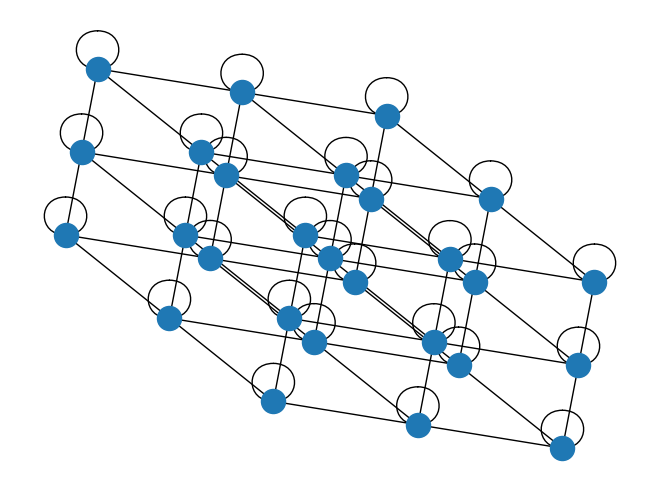

In [10]:
import networkx as nx
import scipy as sp
n = 3
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(sp.sparse.kron(lp1, e), e) + sp.sparse.kron(sp.sparse.kron(e, lp1), e) + sp.sparse.kron(sp.sparse.kron(e, e), lp1)
A = spsp.csc_matrix(A)
G = nx.Graph(A)
nx.draw(G, pos=nx.spectral_layout(G))#, node_size=1)

## What is fill-in?

- The fill-in of a matrix are those entries which change from an initial zero to a nonzero value during the execution of an algorithm.

- The fill-in is different for different permutations. So, before factorization we need to find reordering which produces the smallest fill-in.

**Example**

$$A = \begin{bmatrix} * & * & * & * & *\\ * & * & 0 & 0 & 0 \\ * & 0  & * & 0 & 0 \\ * & 0 & 0& * & 0 \\ * & 0 & 0& 0 & * \end{bmatrix} $$

If we eliminate elements from the top to the bottom, then we will obtain dense matrix.
However, we could maintain sparsity if elimination was done from the bottom to the top.

## Example of dense factors after LU 

Given matrix $A=A^*>0$ we calculate its Cholesky decomposition $A = LL^*$.

Factor $L$ can be dense even if $A$ is sparse:

$$
\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\ * & * &  &  \\ * & * & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * & * & * & * \\  & * & * & * \\  &  & * & * \\  &  &  & * \end{bmatrix}
$$

How to make factors sparse, i.e. to minimize the **fill-in**?

## Why permutations can reduce fill-in? Here the example...

We need to find a permutation of indices so that factors are sparse, i.e. we build Cholesky factorisation of $PAP^\top$, where $P$ is a permutation matrix.

For the example from the previous slide

$$
P \begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} P^\top = 
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\  & * &  &  \\  &  & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\  & &  & * \end{bmatrix}
$$

where

$$
P = \begin{bmatrix}  &  &  & 1 \\  &  & 1 &  \\  & 1 &  &  \\ 1 &  &  &  \end{bmatrix}
$$

- Arrowhead form of the matrix gives sparse factors in LU decomposition

Original matrix


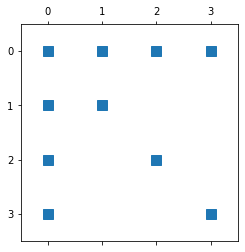

L factor


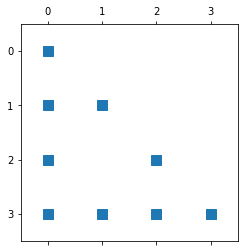

U factor


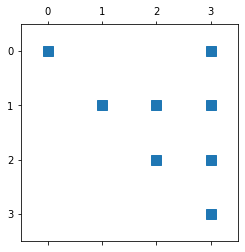

Column permutation: [0 1 2 3]
Row permutation: [1 3 2 0]


In [13]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
%matplotlib inline

A = spsp.coo_matrix((np.random.randn(10), ([0, 0, 0, 0, 1, 1, 2, 2, 3, 3], 
                                           [0, 1, 2, 3, 0, 1, 0, 2, 0, 3])))
print("Original matrix")
plt.spy(A)
plt.show()
lu = spsplin.splu(A.tocsc(), permc_spec="NATURAL")
print("L factor")
plt.spy(lu.L)
plt.show()
print("U factor")
plt.spy(lu.U)
plt.show()
print("Column permutation:", lu.perm_c)
print("Row permutation:", lu.perm_r)

## Block version of appropriate sparsity pattern (arrowhead structure)

$$
PAP^\top = \begin{bmatrix} A_{11} &  & A_{13} \\  & A_{22} & A_{23} \\ A_{31} & A_{32} & A_{33}\end{bmatrix}
$$

then

$$
PAP^\top = \begin{bmatrix} A_{11} & 0 & 0 \\ 0 & A_{22} & 0 \\ A_{31} & A_{32} & A_{33} - A_{31}A_{11}^{-1} A_{13} - A_{32}A_{22}^{-1}A_{23} \end{bmatrix} \begin{bmatrix}  I & 0 & A_{11}^{-1}A_{13} \\ 0 & I & A_{22}^{-1}A_{23} \\ 0 & 0 & I\end{bmatrix}
$$

- Block $ A_{33} - A_{31}A_{11}^{-1} A_{13} - A_{32}A_{22}^{-1}A_{23}$ is Schur complement for block diagonal matrix $\begin{bmatrix} A_{11} & 0 \\ 0 & A_{22} \end{bmatrix}$
- We reduce problem to solving smaller linear systems with $A_{11}$ and $A_{22}$ 

## What we can do to minimize fill-in?

- Reordering the rows and the columns of the sparse matrix in order to reduce the number of nonzeros in $L$ and $U$ factors is called **fill-in** minimization.

- Unfortunately, [this paper](http://i.stanford.edu/pub/cstr/reports/cs/tr/75/531/CS-TR-75-531.pdf) by Rose and Tarjan in 1975 proves that fill-in minimization problem is **NP-complete**.

- But, many heuristics exist:

    - **Markowitz pivoting** - order by the product of nonzeros in column and row and stability constraint
    - **Minimum degree ordering** - order by the degree of the vertex
    - **Cuthill–McKee algorithm** (and reverse Cuthill-McKee) - reorder to minimize the bandwidth (does not exploit graph representation).
    - **Nested dissection**: split the graph into two with minimal number of vertices on the separator (set of vertices removed after we separate the graph into two distinct connected graphs). <br> Complexity of the algorithm depends on the size of the graph separator. For 1D Laplacian separator contains only 1 vertex, in 2D - $\sqrt{N}$ vertices.

### How can we find permutation?

- Key idea comes from graph theory
- Sparse matrix can be treated as an **adjacency matrix** of a certain graph:
the vertices $(i, j)$ are connected, if the corresponding matrix element is non-zero.


### Example

Graphs of $\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix}$ and $\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix}$ have the following form:

<img src="graph_dense.png" width=300 align="center"> and <img src="graph_sparse.png" width=300 align="center">

* Why the second ordering is better than the first one?

## Fill-in upper bound minimization: Markowitz pivoting

- General purpose approach to ordering the elements of sparse matrix that will be eliminated
- The Markowitz merit for every non-zero element with indices $(i, j)$ is computed as $(r_i - 1)(c_j - 1)$, where $r_i$ is number of nonzeros elements in the $i$-th row and $c_j$ is a number of non-zero elements in the $j$-th column
- This value is an upper abound on the fill-in after eliminating the $(i, j)$ element. **Why?**
- We can order elements with respect to these values, select the one with minimum value, eliminate it and update matrix. What about stability?
- Then re-compute these values and repeat the procedure
- This method gives us the permutations of rows and columns and sparse factors
- Main drawback is efficient supporting number of nnz in every row and column after matrix update without complete re-calculating
- More details can be found in book [Direct Methods for Sparse Matrices by I. S. Duff, A. M. Erisman, and J. K. Reid](https://oxford.universitypressscholarship.com/view/10.1093/acprof:oso/9780198508380.001.0001/acprof-9780198508380)
- De facto standard approach in solving Linear programming (LP) problems and their MILP modifications

## What if consider only neighbours? We get minimal degree ordering!

- The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat. How it relates to Markowitz pivoting?

- Efficient implementation is an issue (adding/removing elements).

- Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

- It is **suboptimal** even for 2D PDE problems

- SciPy sparse package [uses](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.splu.html) minimal ordering approach for different matrices ($A^{\top}A$, $A + A^{\top}$) 

## But in these methods we ignore the knowledge of good structure for sparse LU! Let's exploit it explicitly in the method!

## How to formalize reduction to block arrowhead form?

**Definition.** A **separator** in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components.

Separator $S$ gives the following ordering for an $N$-vertex graph $G$:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, enumeration in this component is arbitrarily

### Separator and block arrowhead structure: example

Separator for the 2D Laplacian matrix 

$$
 A_{2D} = I \otimes A_{1D} + A_{1D} \otimes I, \quad A_{1D} = \mathrm{tridiag}(-1, 2, -1),
$$

is as follows

<img src='separator.png' width=300> </img>

Once we have enumerated first indices in $\alpha$, then in $\beta$ and separators indices in $\sigma$ we get the following matrix

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} &  & A_{\alpha\sigma} \\  & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

which has arrowhrad structure.

- Thus, the problem of finding **permutation** was reduced to the problem of finding **graph separator**!

## The method of recursive reduction to block arrowhead structure – Nested dissection

- For blocks $A_{\alpha\alpha}$, $A_{\beta\beta}$ we continue splitting recursively.

- When the recursion is done, we need to eliminate blocks $A_{\sigma\alpha}$ and $A_{\sigma\beta}$. 

- This makes block in the position of $A_{\sigma\sigma}\in\mathbb{R}^{n\times n}$ dense.

Calculation of Cholesky of this block costs $\mathcal{O}(n^3) = \mathcal{O}(N^{3/2})$, where $N = n^2$ is the total number of nodes.

So, the complexity is $\mathcal{O}(N^{3/2})$

## Packages for nested dissection

- MUltifrontal Massively Parallel sparse direct Solver ([MUMPS](http://mumps.enseeiht.fr/))
- [Pardiso](https://www.pardiso-project.org/)
- [Umfpack as part of SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html)

All of them have interfaces for C/C++, Fortran and Matlab 

### Nested dissection summary

- Enumeration: find a separator.
- Divide-and-conquer paradigm
- Recursively process two subsets of vertices after separation
- In theory, nested dissection gives optimal complexity. 
- In practice, it beats others only for very large problems.

## Separators in practice

- Computing separators is not a **trivial task**.

- Graph partitioning heuristics has been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph) - more details below
- Geometric partitioning (for meshes with specified vertex coordinates) [review and analysis](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.4886&rep=rep1&type=pdf)
- Iterative-swapping ([(Kernighan-Lin, 1970)](http://xilinx.asia/_hdl/4/eda.ee.ucla.edu/EE201A-04Spring/kl.pdf), [(Fiduccia-Matheysses, 1982](https://dl.acm.org/citation.cfm?id=809204))
- Breadth-first search [(Lipton, Tarjan 1979)](http://www.cs.princeton.edu/courses/archive/fall06/cos528/handouts/sepplanar.pdf)
- Multilevel recursive bisection (heuristic, currently most practical) ([review](https://people.csail.mit.edu/jshun/6886-s18/lectures/lecture13-1.pdf) and [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.499.4130&rep=rep1&type=pdf)). Package for such kind of partitioning is called METIS, written in C, and available [here](http://glaros.dtc.umn.edu/gkhome/views/metis)

## One of the ways to construct separators – spectral graph partitioning

- The idea of spectral partitioning goes back to Miroslav Fiedler, who studied connectivity of graphs ([paper](https://dml.cz/bitstream/handle/10338.dmlcz/101168/CzechMathJ_23-1973-2_11.pdf)).

- We need to split the vertices into two sets.

- Consider +1/-1 labeling of vertices and **the cost**

$$E_c(x) = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2, \quad N(j) \text{ denotes set of neighbours of a node } j. $$

- We need a balanced partition, thus 

$$\sum_i x_i =  0 \quad \Longleftrightarrow \quad x^\top e = 0, \quad e = \begin{bmatrix}1 & \dots & 1\end{bmatrix}^\top,$$

and since we have +1/-1 labels, we have

$$\sum_i x^2_i = n \quad \Longleftrightarrow \quad \|x\|_2^2 = n.$$

## Graph Laplacian

Cost $E_c$ can be written as (check why)

$$E_c = (Lx, x)$$

where $L$ is the **graph Laplacian**, which is defined as a symmetric matrix with

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \quad \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $0$ and gives trivial eigenvector of all ones.
- Eigenvalues are non-negative (why?).

## Partitioning as an optimization problem

- Minimization of $E_c$ with the mentioned constraints leads to a partitioning that tries to minimize number of edges in a separator, while keeping the partition balanced. 

- We now relax the integer quadratic programming to the continuous quadratic programming

$$E_c(x) = (Lx, x)\to \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}}$$

## From Fiedler vector to separator

- The solution to the minimization problem is given by the eigenvector (called Fiedler vector) corresponding  to the second smallest eigenvalue of the graph Laplacian. Indeed,

$$
    \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}} (Lx, x) = n \cdot \min_{{x^\top e =0}} \frac{(Lx, x)}{(x, x)} = n \cdot \min_{{x^\top e =0}} R(x), \quad R(x) \text{ is the Rayleigh quotient}
$$

- Since $e$ is the eigenvector, corresponding to the smallest eigenvalue, on the space $x^\top e =0$ we get the second minimal eigevalue.

- The sign $x_i$ indicates the partitioning.

- In computations, we need to find out, how to find this second minimal eigenvalue –– we at least know about power method, but it finds the largest. We will discuss iterative methods for eigenvalue problems later in our course.

- This is the main goal of the iterative methods for large-scale linear problems, and can be achieved via few matrix-by-vector products.

Number of vertices = 34
Number of edges = 78


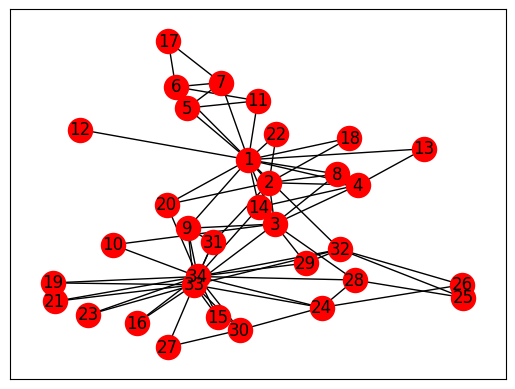

In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
kn = nx.read_gml('karate.gml')
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
nx.draw_networkx(kn, node_color="red") #Draw the graph

<class 'networkx.utils.decorators.argmap'> compilation 21:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


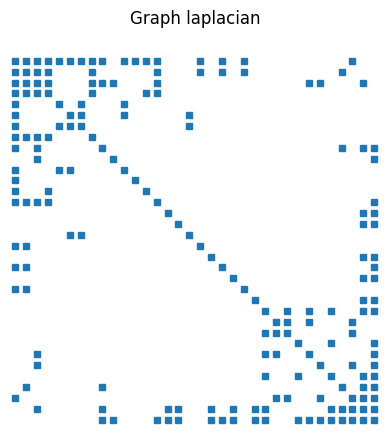

The 2 smallest eigenvalues = [-3.37640596e-15  4.68525227e-01]


In [12]:
import scipy.sparse.linalg as spsplin
Laplacian = nx.laplacian_matrix(kn).asfptype()
plt.spy(Laplacian, markersize=5)
plt.title("Graph laplacian")
plt.axis("off")
plt.show()
eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
print("The 2 smallest eigenvalues =", eigval)

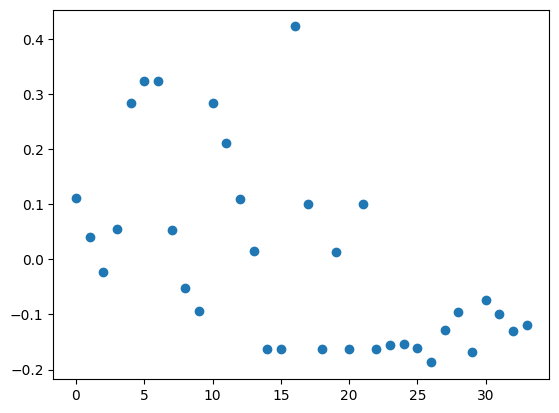

Sum of elements in Fiedler vector = 2.4702462297909733e-15


In [14]:
#plt.scatter(np.arange(len(eigvec[:, 1])), np.sign(eigvec[:, 1]))
plt.scatter(np.arange(len(eigvec[:, 1])), eigvec[:, 1])

plt.show()
print("Sum of elements in Fiedler vector = {}".format(np.sum(eigvec[:, 1].real)))

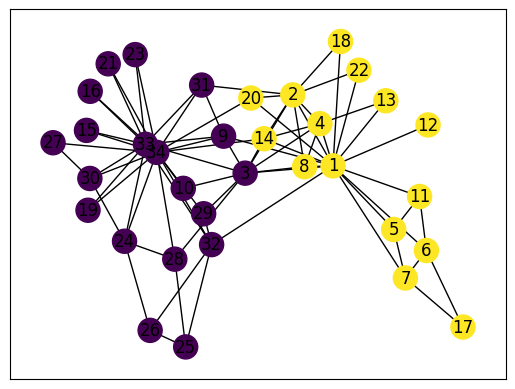

In [15]:
nx.draw_networkx(kn, node_color=np.sign(eigvec[:, 1]))

### Summary on demo

- Here we call SciPy sparse function to find fixed number of eigenvalues (and eigenvectors) that are smallest (other options are possible)
- Details of the underlying method we will discuss soon
- Fiedler vector gives simple separation of the graph
- To separate graph on more than two parts you should use eigenvectors of laplacian as feature vectors and run some clustering algorithm, e.g. $k$-means

## From Fiedler vector to separator

- Elements of eigenvector $v$ corresponding to the second smallest eigenvalue of the Laplacian indicate the partitioning of vertices
- If we select some small positive $\tau >0$, then we can split the vertices in three groups
    - $v_i < -\tau$
    - $v_i \in [-\tau, \tau]$
    - $v_i > \tau$
- After that the separator is composed with the vertices corresponding to elements of $v$ such that $v_i \in [-\tau, \tau]$ 
- The size of separator can be tuned by the magnitude of $\tau$
- The distribution of elements in $v$ is important to identify the size of separator

### Fiedler vector and algebraic connectivity of a graph

**Definition.** The algebraic connectivity of a graph is the second-smallest eigenvalue of the Laplacian matrix.

**Claim.** The algebraic connectivity of a graph is greater than 0 if and only if a graph is a connected graph.

## Practical problems

Computing bisection recursively is expensive. 

As an alternative, one typically computes **multilevel bisection** that consists of 3 phases.

- Graph coarsening: From a given graph, we join vertices into larger nodes, and get sequences of graphs $G_1, \ldots, G_m$. 
- At the coarse level, we do high-quality bisection
- Then, we do **uncoarsening**: we propagate the splitting from $G_k$ to $G_{k-1}$ and improve the quality of the split by local optimization algorithms (refinement). 

## Practical problems (2)

- Once the permutation has been computed, we need to implement the elimination, making use of efficient computational kernels. 

- If in the elemination we will be able to get the elements into **blocks**, we will be able to use BLAS-3 computations. 

- It is done by **supernodal** data structures: 

- If adjacent rows have the same sparsity structure, they can be stored in **blocks**:

- Also, we can use such structure in efficient computations!

[Details in this survey](https://arxiv.org/pdf/1907.05309.pdf)

## Take home message

- Sparse matrices & graphs ordering
- Ordering is important for LU fill-in: more details in the next lecture
- Markowitz pivoting and minimal degree ordering
- Orderings from SciPy sparse package
- Separators and how do they help in fill-in minimization
- Nested dissection idea
- Fiedler vector and spectral bipartitioning

## Plan for the next lecture

- Basic iterative methods for solving large linear systems
- Convergence 
- Acceleration

# Questions?

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()